# REVIEWS AS A PREDICTOR OF SALES
###### By Rachel Nord, DS-SEA-07

## Background / Problem Statement
Reviews drive orders.  We know that products that have reviews and have high average rating of reviews sell better than those that don’t.  However, are there features in the ratings that are more likely to drive purchases than others?  And can we use these features to build a model that will predict orders placed?


## Data
### Data Import
I uploaded a csv file of from Bazaarvoice, the vendor we use to capture and enable user generated content on rei.com. The dimensions of this data are by average overall rating, total reviews, percent recommended to a friend, average estimated word count, percent of reviews that were 5-star, specialty shop, number of uploaded photos, price.

I then joined this data with data on orders placed, price of item, and each level of of REI's internal merchandising hierarchy (Specialty Shop, Department, Class, Subclass).

### Pre-processing Steps Taken


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 14


Most preprocessing was done in prior to the data import since I used SQL to join my two data sources.  At this point I calculated the standard deviation of the review scores for each product.  The Bazaarvoice data is based on a moment in time on 10/20/17.  So I filtered order and traffic data for the month of October.  I also created dummy variables for each specialty shop.

The end result was 18,297 different products and 37 different features to analyze.

In [152]:
# read in data
path = '/Users/rnord/GA Data Science/temp_repos/DS-SEA-07/project/'
url = path + 'Bazaar_by_product_TRAFFIC.csv'
prod = pd.read_csv(url, delimiter = '|')

# Add Standard Deviation
prod['STD'] = np.sqrt(prod['VARIANCE_'])

#Look at latest month
prod_oct = prod[prod['MONTH_CODE'] == 201710]


In [153]:
# create dummy variables for shop
shop_dummies = pd.get_dummies(prod_oct.SHOP_DESC, prefix='shop')


In [154]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
prod_oct = pd.concat([prod_oct, shop_dummies], axis=1)

# print 5 random rows
prod_oct.sample(n=5, random_state=1)


,MONTH_CODE,PRODUCT,SUBCLASS_DESC,CLASS_DESC,DEPARTMENT_DESC,SHOP_DESC,VISITS,ORDERS,CONVERSION,INDEX,...,shop_CLIMBING,shop_CYCLING,"shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS",shop_MISCELLANEOUS,shop_OUTDOOR CROSS TRAINING,shop_OUTDOOR ESSENTIALS,shop_REI GARAGE,shop_SNOWSPORTS,shop_TRAVEL,shop_WATERSPORTS
56311,201710,790592,SNACK BARS,BARS,FOOD,OUTDOOR ESSENTIALS,58,5,0.086207,39962,...,0,0,0,0,0,1,0,0,0,0
45272,201710,122278,SNOWSHOES,CYCLE-SNOW-PADDLE,REI GARAGE,REI GARAGE,437,18,0.041190,44694,...,0,0,0,0,0,0,1,0,0,0
74790,201710,898239,TOPS,WOMEN'S TOPS,WOMEN'S UNDERWEAR,OUTDOOR CROSS TRAINING,129,7,0.054264,62095,...,0,0,0,0,1,0,0,0,0,0
39673,201710,747206,NON WATERPROOF,WOMEN'S HIKING MID HEIGHT,HIKING FOOTWEAR,"HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS",45,4,0.088889,51003,...,0,0,1,0,0,0,0,0,0,0
73475,201710,858583,GUIDES,BOOKS,OUTDOOR IMPULSE,OUTDOOR ESSENTIALS,24,0,0.000000,27687,...,0,0,0,0,0,1,0,0,0,0


### Features Used

In [155]:
prod_oct.columns


Index([u'MONTH_CODE', u'PRODUCT', u'SUBCLASS_DESC', u'CLASS_DESC',
       u'DEPARTMENT_DESC', u'SHOP_DESC', u'VISITS', u'ORDERS', u'CONVERSION',
       u'INDEX', u'PRODUCT_NAME', u'PRODUCT_ID', u'CATEGORY',
       u'AVERAGE_OVERALL_RATING', u'TOTAL_SUBMITTED__REVIEWS',
       u'TOTAL_SUBMITTED__RATINGS_ONLY_REVIEWS', u'PCT_RECOMMEND_TO_A_FRIEND',
       u'AVERAGE_EST_REVIEW_WORD_COUNT', u'PCT_5_STAR', u'PCT_4_STAR',
       u'PCT_3_STAR', u'PCT_2_STAR', u'PCT_1_STAR', u'TOTAL_HELPFULNESS_VOTES',
       u'PCT_YES', u'PCT_NO', u'NUM_UPLOADED_PHOTOS', u'NUM_UPLOADED_VIDEOS',
       u'PRODUCT.1', u'PRICE', u'REVIEWS_5', u'REVIEWS_4', u'REVIEWS_3',
       u'REVIEWS_2', u'REVIEWS_1', u'VARIANCE_', u'STD', u'shop_APPAREL',
       u'shop_CAMPING', u'shop_CLIMBING', u'shop_CYCLING',
       u'shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS', u'shop_MISCELLANEOUS',
       u'shop_OUTDOOR CROSS TRAINING', u'shop_OUTDOOR ESSENTIALS',
       u'shop_REI GARAGE', u'shop_SNOWSPORTS', u'shop_TRAVEL',
      

### Response Variable
The response variable that was tested was `Orders`.

### Data Exploration
- Total number of reviews written for each product

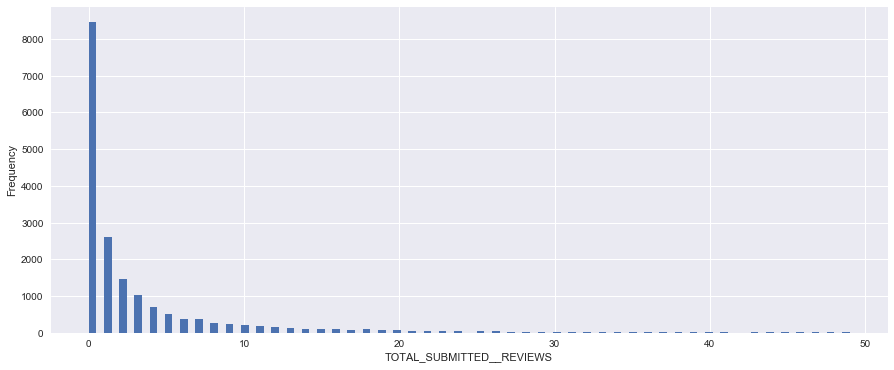

In [156]:
# Total Submitted Reviews
prod_oct.TOTAL_SUBMITTED__REVIEWS[prod_oct.TOTAL_SUBMITTED__REVIEWS < 50].plot(kind='hist', bins=100)
plt.xlabel('TOTAL_SUBMITTED__REVIEWS')
plt.ylabel('Frequency')

- Of all products currently available on rei.com, most have no reviews, followed by those with an average score of 5.

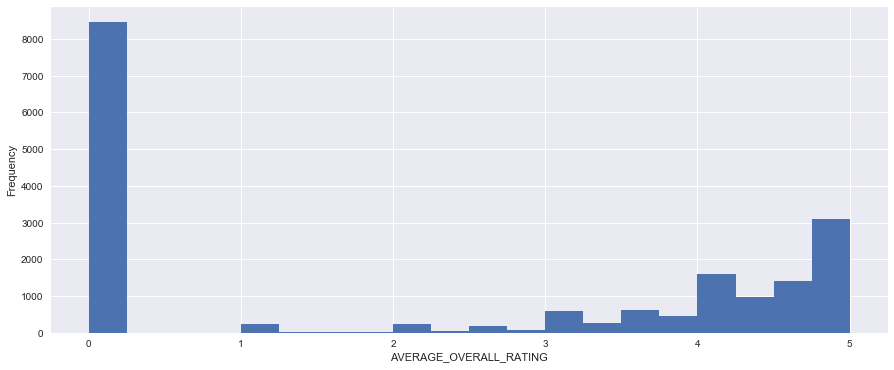

In [157]:
# Average Overall Rating
prod_oct.AVERAGE_OVERALL_RATING.plot(kind='hist', bins=20)
plt.xlabel('AVERAGE_OVERALL_RATING')
plt.ylabel('Frequency')

- Most products fall into the Garage category (which are all discounted products); followed by Camping

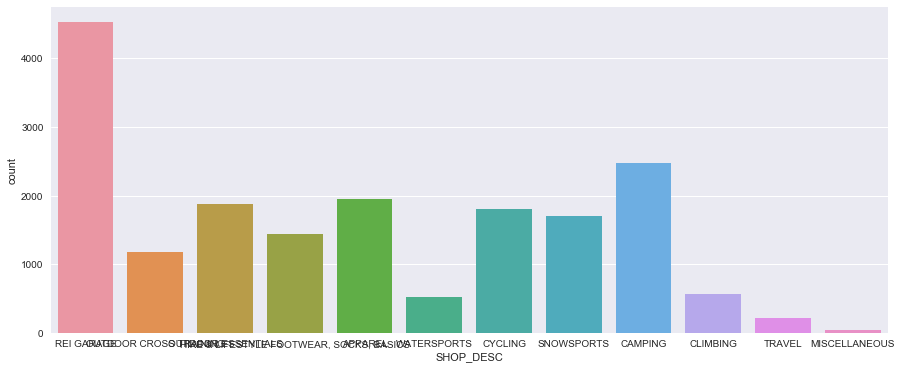

In [158]:
sns.countplot(x='SHOP_DESC', data=prod_oct)

### Correlation Heat Map

Based on the below heatmap, the strongest correlation with orders and order conversion are percent of reviews recommended to friends, total reviews, especially the number of 5-star reviews, total helpfulness votes.

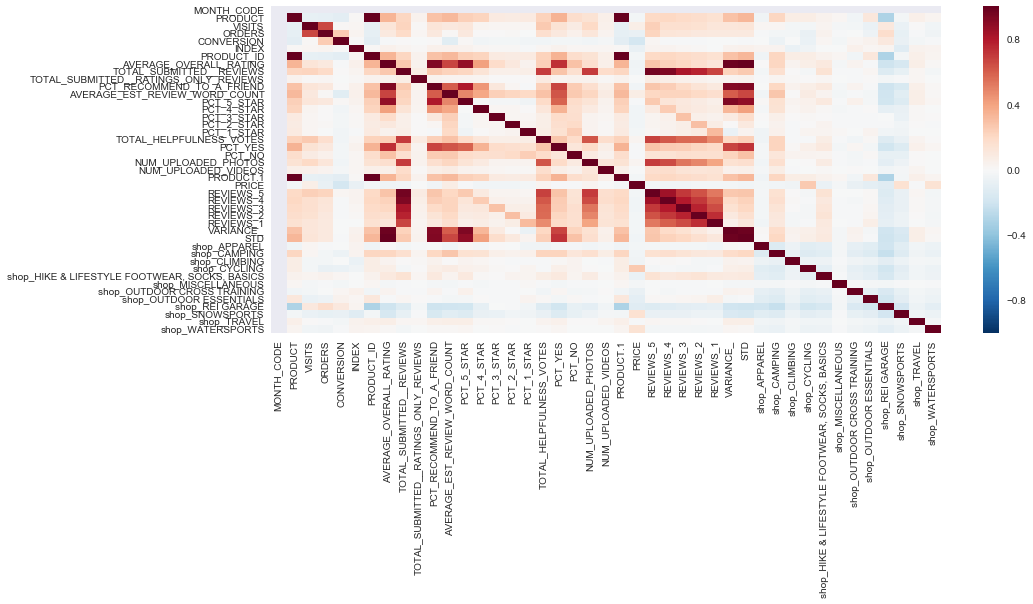

In [159]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(prod_oct.corr())

In [160]:
# create a list of features
feature_cols = ['AVERAGE_OVERALL_RATING', 'TOTAL_SUBMITTED__REVIEWS', 
                'TOTAL_SUBMITTED__RATINGS_ONLY_REVIEWS', 'PCT_RECOMMEND_TO_A_FRIEND',
                'AVERAGE_EST_REVIEW_WORD_COUNT', 'PCT_5_STAR', 'PCT_4_STAR', 'PCT_3_STAR', 'PCT_2_STAR', 'PCT_1_STAR', 
                'PCT_YES', 'PCT_NO', 'NUM_UPLOADED_PHOTOS', 'NUM_UPLOADED_VIDEOS', 'PRICE', 'REVIEWS_5', 
                'REVIEWS_4', 'REVIEWS_3', 'REVIEWS_2', 'REVIEWS_1', 'VARIANCE_', 'STD', 'shop_APPAREL', 'shop_CAMPING', 
                'shop_CLIMBING', 'shop_CYCLING', 'shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS', 'shop_MISCELLANEOUS', 
                'shop_OUTDOOR CROSS TRAINING', 'shop_OUTDOOR ESSENTIALS', 'shop_REI GARAGE', 'shop_SNOWSPORTS', 'shop_TRAVEL', 
                'shop_WATERSPORTS']



In [161]:
# Creation of feature matrix and response vector
# Importation of chosen estimato; instantiation into a variable
# Fit the model with the X and y

X = prod_oct[feature_cols]
y = prod_oct['ORDERS']

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:

# print the coefficients
print linreg.intercept_
print linreg.coef_


5.82686471781
[ -5.26552356e+01   3.03166251e+00   9.13249955e-01   6.66304928e+00
  -4.09352609e-02   2.56868026e+02   2.02791826e+02   1.45170906e+02
   9.79869520e+01   4.27050793e+01   6.53581819e+00   6.47257194e+00
  -6.28115531e-01   2.64076055e+00  -3.40301591e-03  -1.49855283e+00
  -5.06061294e+00  -2.63076201e+00  -3.78273794e+00  -2.44111797e+00
  -2.38504732e-01   3.07719950e+00   2.93753747e+00  -2.74380280e+00
  -2.58135143e+00  -3.91894038e+00   2.69262963e+00  -6.12141344e+00
   1.78310327e+00  -2.87094734e+00   1.94959197e+01  -1.20987092e+00
  -3.93644050e+00  -3.52642330e+00]


In [163]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('AVERAGE_OVERALL_RATING', -52.655235583361723),
 ('TOTAL_SUBMITTED__REVIEWS', 3.0316625127679053),
 ('TOTAL_SUBMITTED__RATINGS_ONLY_REVIEWS', 0.91324995509292184),
 ('PCT_RECOMMEND_TO_A_FRIEND', 6.6630492822762193),
 ('AVERAGE_EST_REVIEW_WORD_COUNT', -0.0409352608946012),
 ('PCT_5_STAR', 256.86802636373284),
 ('PCT_4_STAR', 202.79182585372962),
 ('PCT_3_STAR', 145.17090571353927),
 ('PCT_2_STAR', 97.9869519547279),
 ('PCT_1_STAR', 42.705079260835198),
 ('PCT_YES', 6.5358181882610538),
 ('PCT_NO', 6.4725719381903586),
 ('NUM_UPLOADED_PHOTOS', -0.62811553124052466),
 ('NUM_UPLOADED_VIDEOS', 2.6407605540965311),
 ('PRICE', -0.0034030159142233174),
 ('REVIEWS_5', -1.4985528329088709),
 ('REVIEWS_4', -5.0606129439552063),
 ('REVIEWS_3', -2.6307620136855121),
 ('REVIEWS_2', -3.7827379364633344),
 ('REVIEWS_1', -2.4411179667822296),
 ('VARIANCE_', -0.23850473235924596),
 ('STD', 3.0771994992459213),
 ('shop_APPAREL', 2.9375374661557481),
 ('shop_CAMPING', -2.7438027982496616),
 ('shop_CLIMB

The most impactful features are:

- Holding all other features fixed, a 1 unit increase in **Pct 5-Star Reviews** is associated with an **order increase of 257 products**.
- Holding all other features fixed, a 1 unit increase in **Average Overall Rating** is associated with a **order increase of 53 products**.
- Holding all other features fixed, a 1 unit increase in **REI Garage Prodcut** is associated with a **order increase of 19 products**.

## Modeling

### Simple Linear Regression
I first ran a simple linear regression model to get a sense of the null RSME.

In [164]:
#from sklearn.cross_validation import train_test_split # deprecated syntax
from sklearn.model_selection import train_test_split
from sklearn import metrics


# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = prod_oct[feature_cols]
    y = prod_oct['ORDERS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))


In [165]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null


array([ 15.29311475,  15.29311475,  15.29311475, ...,  15.29311475,
        15.29311475,  15.29311475])

In [166]:
np.sqrt(metrics.mean_squared_error(y_test, y_null))

39.827584512652969

Changing the random state in the test/train split gave me a null RSME ranging from **34 to 40**.


### Cross Validation

I next used a 10-fold cross-validation to calculate the RMSE for the linear regression model.  The RMSE when using all features was 36.81. 

In [167]:
# save the 10 MSE scores output by cross_val_score
from sklearn.model_selection import cross_val_score
mse_scores = cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')
print mse_scores
print np.mean(np.sqrt(-mse_scores))

[-1768.51303543 -1623.55252236 -1218.91319338  -678.66206974 -2179.63185167
 -1070.82500042 -1021.76958623 -1385.60057806 -1180.67262934 -1750.35384928]
36.810802857


Then I tuned my model, attempting to increase the accuracy by excluding some of the features from the model.
Of the models I ran, this was the only one that beat the cross-validation model with all features included:
- 'PCT_RECOMMEND_TO_A_FRIEND'
- 'AVERAGE_EST_REVIEW_WORD_COUNT' 
- 'PCT_YES'
- 'PCT_NO'
- 'PRICE'
- 'REVIEWS_5' 
- 'REVIEWS_4'
- 'REVIEWS_1'
- 'shop_CAMPING' 
- 'shop_CLIMBING'
- 'shop_CYCLING'
- 'shop_MISCELLANEOUS' 
- 'shop_OUTDOOR ESSENTIALS'
- 'shop_REI GARAGE'
- 'shop_SNOWSPORTS'
- 'shop_TRAVEL' 
- 'shop_WATERSPORTS' 


In [168]:
# 10-fold cross-validation with best test-train features
# this was the best combo I could find.
feature_cols = [ 'PCT_RECOMMEND_TO_A_FRIEND',
                'AVERAGE_EST_REVIEW_WORD_COUNT', 
                'PCT_YES', 'PCT_NO', 'PRICE', 'REVIEWS_5', 
                'REVIEWS_4', 'REVIEWS_1', 'shop_CAMPING', 
                'shop_CLIMBING', 'shop_CYCLING', 'shop_MISCELLANEOUS', 
                'shop_OUTDOOR ESSENTIALS', 'shop_REI GARAGE', 'shop_SNOWSPORTS', 'shop_TRAVEL', 
                'shop_WATERSPORTS']
X = prod_oct[feature_cols]

mse_scores = cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')
print mse_scores
print np.sqrt(-cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')).mean()

[-1765.61127464 -1625.79836302 -1218.00575853  -678.9925136  -2178.6370261
 -1069.78461497 -1018.08719135 -1373.74348905 -1179.82359175 -1741.34408722]
36.7730725297


A sampling of the other combinations I tried:

In [169]:
# 10-fold cross-validation with best test-train features
feature_cols = ['PCT_5_STAR',  'PCT_4_STAR', 'PCT_3_STAR',  'PCT_2_STAR',  'PCT_1_STAR',  'AVERAGE_OVERALL_RATING', 
                       'shop_REI GARAGE', 'TOTAL_SUBMITTED__RATINGS_ONLY_REVIEWS', 'STD',  'TOTAL_SUBMITTED__REVIEWS',  
                       'PCT_RECOMMEND_TO_A_FRIEND',  'PCT_YES',  'shop_CAMPING',  'REVIEWS_5',  'shop_OUTDOOR ESSENTIALS', 
                       'shop_APPAREL', 'shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS',  'PRICE']
X = prod_oct[feature_cols]
print np.sqrt(-cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')).mean()

36.9522125235


In [170]:
# 10-fold cross-validation with best test-train features
feature_cols = ['shop_REI GARAGE', 'PCT_5_STAR', 'PCT_YES', 'PCT_RECOMMEND_TO_A_FRIEND', 
                       'shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS', 'shop_APPAREL', 'shop_OUTDOOR CROSS TRAINING', 
                       'TOTAL_SUBMITTED__REVIEWS', 'PCT_1_STAR']
X = prod_oct[feature_cols]
print np.sqrt(-cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')).mean()

37.3154109583


In [171]:
# 10-fold cross-validation with best test-train features
feature_cols = ['AVERAGE_OVERALL_RATING', 'PCT_RECOMMEND_TO_A_FRIEND', 'PCT_YES', 'NUM_UPLOADED_PHOTOS', 
                       'PCT_5_STAR']
X = prod_oct[feature_cols]
print np.sqrt(-cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')).mean()

38.7904094593


## Dimension Reduction - Principal Component Analysis
As was evident in the heat map in the Data Exploration section, several features in my model have high correlation with each other.  My next step was to eliminate the redundancy in the feature columns and to come up with simpler but no less accurate model.

In [172]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.model_selection import cross_val_score

In [173]:
# return X to ALL Feature Columns
feature_cols = ['AVERAGE_OVERALL_RATING', 'TOTAL_SUBMITTED__REVIEWS', 
                'TOTAL_SUBMITTED__RATINGS_ONLY_REVIEWS', 'PCT_RECOMMEND_TO_A_FRIEND',
                'AVERAGE_EST_REVIEW_WORD_COUNT', 'PCT_5_STAR', 'PCT_4_STAR', 'PCT_3_STAR', 'PCT_2_STAR', 'PCT_1_STAR', 
                'PCT_YES', 'PCT_NO', 'NUM_UPLOADED_PHOTOS', 'NUM_UPLOADED_VIDEOS', 'PRICE', 'REVIEWS_5', 
                'REVIEWS_4', 'REVIEWS_3', 'REVIEWS_2', 'REVIEWS_1', 'VARIANCE_', 'STD', 'shop_APPAREL', 'shop_CAMPING', 
                'shop_CLIMBING', 'shop_CYCLING', 'shop_HIKE & LIFESTYLE FOOTWEAR, SOCKS, BASICS', 'shop_MISCELLANEOUS', 
                'shop_OUTDOOR CROSS TRAINING', 'shop_OUTDOOR ESSENTIALS', 'shop_REI GARAGE', 'shop_SNOWSPORTS', 'shop_TRAVEL', 
                'shop_WATERSPORTS']
X = prod_oct[feature_cols]

explained variance ratio (all 34 components):  [  9.14739485e-01   6.77318729e-02   1.31067354e-02   4.27217336e-03
   8.23755761e-05   2.61847551e-05   1.09924657e-05   7.63300251e-06
   6.83288039e-06   3.72121490e-06   2.25535394e-06   1.37121558e-06
   1.20452037e-06   1.08383798e-06   1.05584327e-06   9.40775109e-07
   8.73219382e-07   7.66669859e-07   5.18031676e-07   4.01815287e-07
   3.31213958e-07   2.98220443e-07   2.45278872e-07   1.75993087e-07
   1.44673700e-07   1.33770261e-07   8.10728548e-08   4.10775166e-08
   2.79760375e-08   2.24971204e-08   2.06563312e-08   1.71018183e-10
   1.56814060e-11   5.25656678e-33]
sum of explained variance ratio (all 34 components):  1.0


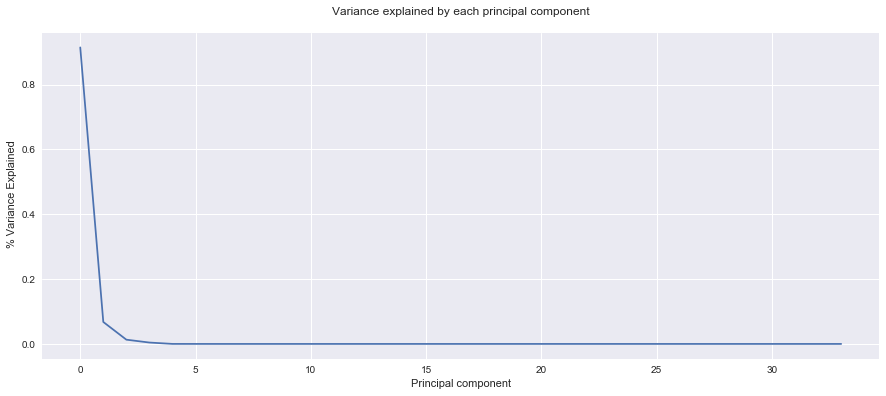

In [174]:
#Choosing components
pca34 = decomposition.PCA(n_components=34)
X_trf = pca34.fit_transform(X)

print 'explained variance ratio (all 34 components): ', pca34.explained_variance_ratio_
print 'sum of explained variance ratio (all 34 components): ', pca34.explained_variance_ratio_.sum()
plt.cla()
plt.plot(pca34.explained_variance_ratio_)
plt.title('Variance explained by each principal component\n')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')

Based on the graph above, I first reduced the number of features from 34 to 5 components

In [175]:

from sklearn import decomposition
pca5 = decomposition.PCA(n_components=5)
X_trf_5 = pca5.fit_transform(X)
print(X_trf_5[0:5])

[[ -99.59544417  -67.55802574   14.70586776   -0.47463225    0.38740568]
 [-109.60742086  120.57198389   21.14069869   25.13994628    2.06109169]
 [ -63.33235368  -68.08704154   14.23528378   -0.38195136    0.37128483]
 [-117.37190434  -67.29695584   14.93528204   -0.51708355    0.39135808]
 [-116.32206967  -67.31200698   14.92103005   -0.51314151    0.39524546]]


With a reduction to 5 components, accuracy compared to my original model is still at nearly 100%.

In [176]:
print pca5.explained_variance_ratio_
print pca5.explained_variance_ratio_.sum()

[  9.14739485e-01   6.77318729e-02   1.31067354e-02   4.27217336e-03
   8.23755761e-05]
0.999932641782


I next tested reductions to fewer components:

In [177]:
#Let's reduce it to 3 components
pca3 = decomposition.PCA(n_components=3)
X_trf_3 = pca3.fit_transform(X)
print pca3.explained_variance_ratio_
print pca3.explained_variance_ratio_.sum()

[ 0.91473948  0.06773187  0.01310674]
0.995578092846


In [178]:
#Let's reduce it to 2 components
pca2 = decomposition.PCA(n_components=2)
X_trf_2 = pca2.fit_transform(X)
print pca2.explained_variance_ratio_
print pca2.explained_variance_ratio_.sum()

[ 0.91473948  0.06773187]
0.982471357459


In [179]:
#Let's reduce it to 1 component
pca1 = decomposition.PCA(n_components=1)
X_trf_1 = pca1.fit_transform(X)
print pca1.explained_variance_ratio_
print pca1.explained_variance_ratio_.sum()

[ 0.91473948]
0.914739484531


In [180]:
linreg = LinearRegression()
mse_scores = cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error')
print mse_scores

[-1768.51303543 -1623.55252236 -1218.91319338  -678.66206974 -2179.63185167
 -1070.82500042 -1021.76958623 -1385.60057806 -1180.67262934 -1750.35384928]


Reminder that the RMSE of my original cross-validation linear regression model was 36.81:

In [181]:
# convert MSE to RMSE, and then calculate the mean of the 10 RMSE scores
rmse_scores = np.sqrt(-mse_scores)
print rmse_scores
print np.mean(rmse_scores)


[ 42.05369229  40.29333099  34.91293734  26.05114335  46.68652752
  32.72346254  31.96513079  37.22365616  34.36091718  41.83723042]
36.810802857


Converting the features into 3 components yielded an RMSE of 39.26.
Converting the features into 5 components yielded an RMSE of 38.37.

Both of these are less accurate than my original cross validation. Let's run a Decision Tree model next.

In [182]:
from sklearn.pipeline import Pipeline
pipe_trf_3 = Pipeline([('pca_3', decomposition.PCA(n_components=3)),
                 ('linear', LinearRegression())])
scores_trf_3 = cross_val_score(pipe_trf_3, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = scores_trf_3.mean()
np.mean(np.sqrt(-rmse_scores))

39.269839797956614

In [183]:
from sklearn.pipeline import Pipeline
pipe_trf_5 = Pipeline([('pca_5', decomposition.PCA(n_components=5)),
                 ('linear', LinearRegression())])
scores_trf_5 = cross_val_score(pipe_trf_5, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = scores_trf_5.mean()
np.mean(np.sqrt(-rmse_scores))

38.372882721354941

### Decision Tree

Use 10-fold cross-validation to evaluate a decision tree model

In [184]:
from sklearn.tree import DecisionTreeRegressor
# list of values to try
max_depth_range = range(1, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use CV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

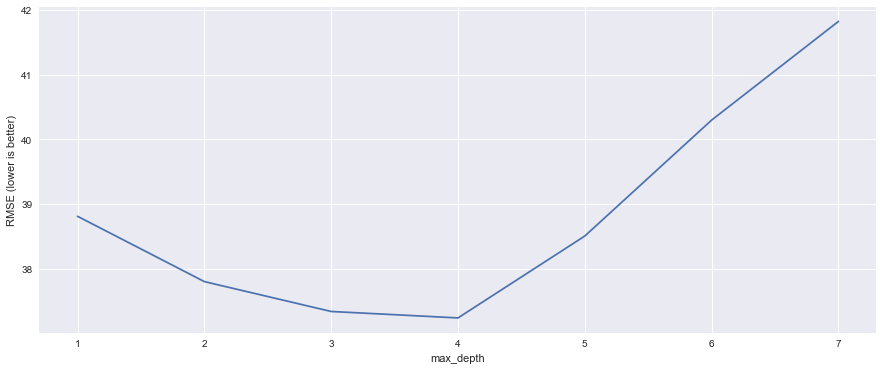

In [185]:
# plot max_depth (x-axis) versus RMSE (y-axis)

plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [186]:
# fit a decision tree model with "max_depth=3"
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)

scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores_t = np.mean(np.sqrt(-scores))
np.mean(rmse_scores_t)

37.342236529554654

In [187]:
# fit a decision tree model with "max_depth=4"
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(max_depth=4, random_state=1)

scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores_t = np.mean(np.sqrt(-scores))
print rmse_scores_t


37.2425417928


So it appears that the best model I can use is a decision tree with a depth of 4, as the RSME is the lowest of all.  This is still less accurate than my null RSME.

## Conclusion

The Root Squared Mean Error for each model/best model tune were:

- Cross Validation linear regression: **39.023**
- Best Cross Validation model produced, based on features used: **36.773**
- Linear regression using Dimensionality Reduction: **38.373**
- Best Decision Tree model: **37.243**

The best model I produced in terms of lowest RSME was a Cross Validation model using select features: 
- 'PCT_RECOMMEND_TO_A_FRIEND'
- 'AVERAGE_EST_REVIEW_WORD_COUNT' 
- 'PCT_YES'
- 'PCT_NO'
- 'PRICE'
- 'REVIEWS_5' 
- 'REVIEWS_4'
- 'REVIEWS_1'
- 'shop_CAMPING' 
- 'shop_CLIMBING'
- 'shop_CYCLING'
- 'shop_MISCELLANEOUS' 
- 'shop_OUTDOOR ESSENTIALS'
- 'shop_REI GARAGE'
- 'shop_SNOWSPORTS'
- 'shop_TRAVEL' 
- 'shop_WATERSPORTS' 
                
Still, this model did not produce results much more accurate than the Null simple linear regression.  None of the features I looked at were very highly correlated with orders placed.  With the data I have available, we cannot produce a model that will predict orders placed with much accuracy.